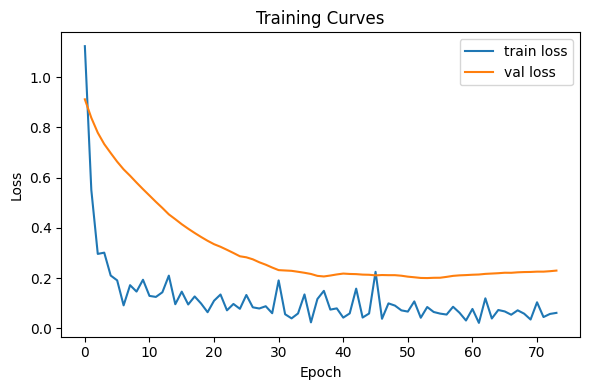

Test Accuracy: 0.9210526315789473

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



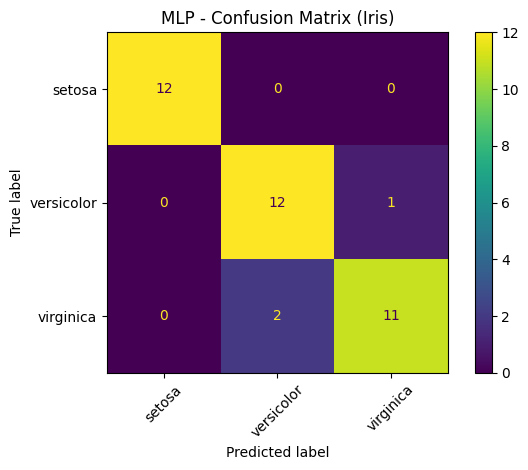


Saved model to mlp_iris.keras and scaler to iris_scaler.joblib

New sample predicted class: setosa


In [23]:
# --- Setup (works in Google Colab) ---
!pip -q install tensorflow scikit-learn matplotlib numpy pandas

# --- Imports ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------- Choose mode: "tabular" or "image" --------
MODE = "tabular"  # change to "image" for CNN on Fashion-MNIST

if MODE == "tabular":
    # ====== TABULAR: MLP on Iris ======
    iris = datasets.load_iris()
    X = iris.data.astype(np.float32)
    y = iris.target.astype(np.int32)
    feature_names = iris.feature_names
    class_names = iris.target_names

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    # Scale features (important for NNs on tabular)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test  = scaler.transform(X_test).astype(np.float32)

    # Build MLP
    def build_mlp(input_dim, num_classes):
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(64, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation="softmax"),
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    model = build_mlp(X_train.shape[1], len(np.unique(y)))

    # Callbacks: early stopping + best checkpoint
    early = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=300,
        batch_size=16,
        verbose=0,
        callbacks=[early, reduce_lr]
    )

    # Training curves
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Curves")
    plt.legend(); plt.tight_layout(); plt.show()

    # Evaluate
    test_probs = model.predict(X_test, verbose=0)
    y_pred = test_probs.argmax(axis=1)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, xticks_rotation=45
    )
    plt.title("MLP - Confusion Matrix (Iris)")
    plt.tight_layout(); plt.show()

    # Save model + scaler
    model.save("mlp_iris.keras")
    import joblib; joblib.dump(scaler, "iris_scaler.joblib")
    print("\nSaved model to mlp_iris.keras and scaler to iris_scaler.joblib")

    # Predict a new sample (Iris order)
    sample = np.array([[5.4, 3.9, 1.7, 0.4]], dtype=np.float32)
    sample_scaled = scaler.transform(sample)
    pred_idx = model.predict(sample_scaled, verbose=0).argmax(axis=1)[0]
    print(f"\nNew sample predicted class: {class_names[pred_idx]}")

elif MODE == "image":
    # ====== IMAGE: CNN on Fashion-MNIST ======
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    class_names = np.array([
        "T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"
    ])

    # Normalize & add channel dim
    X_train = (X_train / 255.0).astype("float32")[..., None]
    X_test  = (X_test  / 255.0).astype("float32")[..., None]

    # Build a small CNN
    def build_cnn():
        model = keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(32, 3, activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(10, activation="softmax"),
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    model = build_cnn()

    early = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=128,
        callbacks=[early],
        verbose=1
    )

    # Training curves
    plt.figure(figsize=(6,4))
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training Curves")
    plt.legend(); plt.tight_layout(); plt.show()

    # Evaluate + report
    test_probs = model.predict(X_test, verbose=0)
    y_pred = test_probs.argmax(axis=1)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, xticks_rotation=45
    )
    plt.title("CNN - Confusion Matrix (Fashion-MNIST)")
    plt.tight_layout(); plt.show()

    # Save model
    model.save("cnn_fashion_mnist.keras")
    print("\nSaved model to cnn_fashion_mnist.keras")

    # Predict one sample
    sample = X_test[:1]
    pred_idx = model.predict(sample, verbose=0).argmax(axis=1)[0]
    print(f"\nPredicted class for first test image: {class_names[pred_idx]}")

else:
    raise ValueError('MODE must be "tabular" or "image"')
